In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tqdm.notebook as tqdm
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
from torchvision import datasets
import pip
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score
import copy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_confusion_matrix
from IPython.display import SVG, display, clear_output

In [ ]:
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*IMAGE TRANSFORMATIONS*

In [ ]:
#calcular la media y la desviacion tipica sobre el conjunto de imagenes 0-1
#Modelos de imagenet están pensados para tomar imagenes de 3 canales
#def apply_image(path):
  #Image.open(path).convert('RGB')
  #ImageDataLoader(loader = apply_image)

  #ImageAugmentation
# -Imagenes : Covid : 1000, Normal 1341, viral 1345 -Image Augmentation

#Modelos a aplicar con transfer learning: -SqueezeNet -MobileNetv2 -ResNet18 -DenseNet201 -VGG19 -WideResnet -ResNext

#Para evaluacion:

#-También aplicar 5-fold cross-validation (accuracy, sensitivity, precision....)

#Optimizador: -SGD con momentum 0.9

In [2]:
normalize_mean = [0.485,0.456,0.406]
normalize_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.RandomHorizontalFlip(), 
  transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
  transforms.Normalize(normalize_mean, normalize_std)
])

In [4]:
!mkdir -p /my_data/

In [5]:
!unzip '/content/drive/MyDrive/COVID_DETECTION/Pneumonia.zip' -d "/my_data"

Archive:  /content/drive/MyDrive/COVID_DETECTION/Pneumonia.zip
   creating: /my_data/Viral Pneumonia/
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (10).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (100).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1000).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1001).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1002).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1003).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1004).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1005).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1006).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1007).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1008).png  
 extracting: /my_data/Viral Pneumonia/Viral Pneumonia (1009).png  
 extracting: /my_data/Viral Pneum

In [6]:
!unzip '/content/drive/MyDrive/COVID_DETECTION/COVID.zip' -d "/my_data"

Archive:  /content/drive/MyDrive/COVID_DETECTION/COVID.zip
   creating: /my_data/COVID/
   creating: /my_data/COVID/COVID/
 extracting: /my_data/COVID/COVID (1).png  
 extracting: /my_data/COVID/COVID (10).png  
 extracting: /my_data/COVID/COVID (100).png  
 extracting: /my_data/COVID/COVID (1000).png  
 extracting: /my_data/COVID/COVID (1001).png  
 extracting: /my_data/COVID/COVID (1002).png  
 extracting: /my_data/COVID/COVID (1003).png  
 extracting: /my_data/COVID/COVID (1004).png  
 extracting: /my_data/COVID/COVID (1005).png  
 extracting: /my_data/COVID/COVID (1006).png  
 extracting: /my_data/COVID/COVID (1007).png  
 extracting: /my_data/COVID/COVID (1008).png  
 extracting: /my_data/COVID/COVID (1009).png  
 extracting: /my_data/COVID/COVID (101).png  
 extracting: /my_data/COVID/COVID (1010).png  
 extracting: /my_data/COVID/COVID (1011).png  
 extracting: /my_data/COVID/COVID (1012).png  
 extracting: /my_data/COVID/COVID (1013).png  
 extracting: /my_data/COVID/COVID (101

In [7]:
!unzip '/content/drive/MyDrive/COVID_DETECTION/NORMAL.zip' -d "/my_data"

Archive:  /content/drive/MyDrive/COVID_DETECTION/NORMAL.zip
   creating: /my_data/NORMAL/
 extracting: /my_data/NORMAL/NORMAL (1).png  
 extracting: /my_data/NORMAL/NORMAL (10).png  
 extracting: /my_data/NORMAL/NORMAL (100).png  
 extracting: /my_data/NORMAL/NORMAL (1000).png  
 extracting: /my_data/NORMAL/NORMAL (1001).png  
 extracting: /my_data/NORMAL/NORMAL (1002).png  
 extracting: /my_data/NORMAL/NORMAL (1003).png  
 extracting: /my_data/NORMAL/NORMAL (1004).png  
 extracting: /my_data/NORMAL/NORMAL (1005).png  
 extracting: /my_data/NORMAL/NORMAL (1006).png  
 extracting: /my_data/NORMAL/NORMAL (1007).png  
 extracting: /my_data/NORMAL/NORMAL (1008).png  
 extracting: /my_data/NORMAL/NORMAL (1009).png  
 extracting: /my_data/NORMAL/NORMAL (101).png  
 extracting: /my_data/NORMAL/NORMAL (1010).png  
 extracting: /my_data/NORMAL/NORMAL (1011).png  
 extracting: /my_data/NORMAL/NORMAL (1012).png  
 extracting: /my_data/NORMAL/NORMAL (1013).png  
 extracting: /my_data/NORMAL/NORMAL

*PREPARAMOS DATASET

In [ ]:
def myloader(filename):
    return Image.open(filename).convert('RGB')

In [3]:
dataset = datasets.ImageFolder('/my_data', transform=transform)

In [ ]:
#dataset = datasets.ImageFolder('/my_data', transform=transform, loader = myloader)Preguntar lo de image

In [4]:
print(dataset.class_to_idx) #Clases asignadas en la función imagefolder a las tres carpetas

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


In [4]:
dataset

Dataset ImageFolder
    Number of datapoints: 5080
    Root location: /my_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.2, 0.2])
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
len(dataset)

5080

DIVIDIMOS DATASET EN TRAIN, VALIDACIÓN Y TEST

In [5]:
n_train = int(0.7*len(dataset))
n_valid_test = (len(dataset)-n_train)
n_valid = int((0.5*(n_valid_test)))
n_test = int((0.5*(n_valid_test)))

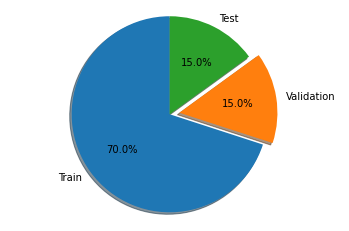

In [6]:
import matplotlib.pyplot as plt


labels = 'Train', 'Validation', 'Test'
sizes = [n_train, n_valid, n_test]
explode = (0, 0.1, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [7]:
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [n_train, n_valid, n_test])

PREPARAMOS DATALOADER

In [8]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle = True)

In [9]:
dataloaders_entrenamiento = {"Train":train_loader, "Validation":val_loader}
data_sizes = {x: len(dataloaders_entrenamiento[x].sampler) for x in ['Train','Validation']}

VISUALIZACIÓN DE LOS DATOS

COVID IMAGE:

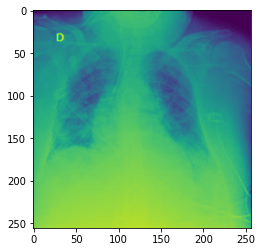

In [12]:
image = plt.imread('/my_data/COVID/COVID (100).png')
plt.imshow(image)

NORMAL IMAGE:

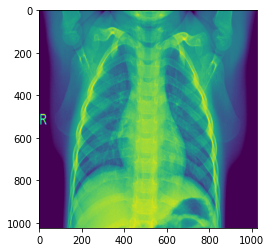

In [ ]:
image = plt.imread('/my_data/NORMAL/NORMAL (1009).png')
plt.imshow(image)

VIRAL PNEUMONIA IMAGE

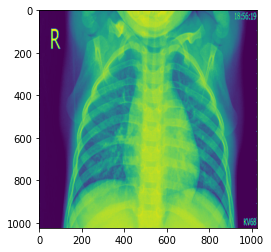

In [ ]:
image = plt.imread('/my_data/Viral Pneumonia/Viral Pneumonia (1030).png')
plt.imshow(image)

In [ ]:
dataset.classes

['COVID', 'NORMAL', 'Viral Pneumonia']

In [ ]:
dataset.class_to_idx

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

**RESNET**


In [10]:
resnet18 = torchvision.models.resnet18(pretrained = True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
resnet18.fc =nn.Sequential( 
               nn.Linear(512, 256),
               nn.ReLU(inplace=True),
               nn.Dropout(p=0.3),
               nn.Linear(256,3)
                                            # nn.Softmax(dim=1)                                             
                                            )
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr = 0.04, momentum = 0.9)

DEFINIMOS LA GRÁFICA DE ENTRENAMIENTO

In [12]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(acc_tr, acc_val, loss_tr, loss_val,
                          figsize=(12,6)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(acc_tr)),  100*np.array(acc_tr))
    plt.plot(1+np.arange(len(acc_val)), 100*np.array(acc_val))
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(acc_tr)), np.array(loss_tr))
    plt.plot(1+np.arange(len(acc_val)), np.array(loss_val))
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

ENTRENAMOS EL MODELO

In [13]:
def train_covid(resnet18, loss_fn, optimizer, epochs=12):
    loss_tr = []
    acc_tr  = []
    loss_val = []
    acc_val = []
    since = time.time()
    best_loss = np.inf
    best_model_wts = copy.deepcopy(resnet18.state_dict())

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 12)

        # Cada epoch tendrá una fase de train y otra de validación
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                resnet18.train()  # Train
            else:
                resnet18.eval()   # Validación

            current_loss = 0.0
            current_acc = 0
            

            #Cogemos los inputs y los almacenamos en un dataloader filtrado por Train y Validation, para poder entrenarlos simultáneamente
            for inputs, labels in tqdm.tqdm(dataloaders_entrenamiento[phase], desc=phase, leave=False):

                #Hacemos 0 los parámetros del gradiente.
                optimizer.zero_grad()

                # BACKWARD PROPAGATION. Se calculan gradientes y se actualizan los pesos
                #Solo se hace el back propagation y se optimiza si es en Train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = resnet18(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # Solo hacemos el backward y optimizamos en train
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                 # Acumulamos las estadísticas de loss y accuracy en variables
                current_loss += loss.item() * inputs.size(0)
                current_acc += torch.sum(preds == labels.data)
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_acc.double() / data_sizes[phase]
            if phase == 'Validation':
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                loss_val.append(epoch_loss)
                acc_val.append(epoch_acc)
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                loss_tr.append(epoch_loss)
                acc_tr.append(epoch_acc)
               

            
            if phase == 'Validation' and epoch_loss < best_loss:
                print('Validation loss decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss 
                best_model_wts = copy.deepcopy(resnet18.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    
    grafica_entrenamiento(acc_tr, acc_val, loss_tr, loss_val)
    return resnet18

Epoch 1/12
------------


Train Loss: 0.3407 | Train Accuracy: 0.8577


Validation Loss: 0.3797 | Validation Accuracy: 0.8688
Validation loss decreased from inf to 0.3797 
Saving Weights... 

Epoch 2/12
------------


Train Loss: 0.1060 | Train Accuracy: 0.9637


Validation Loss: 0.1557 | Validation Accuracy: 0.9514
Validation loss decreased from 0.3797 to 0.1557 
Saving Weights... 

Epoch 3/12
------------


Train Loss: 0.0877 | Train Accuracy: 0.9693


Validation Loss: 0.1277 | Validation Accuracy: 0.9423
Validation loss decreased from 0.1557 to 0.1277 
Saving Weights... 

Epoch 4/12
------------


Train Loss: 0.0573 | Train Accuracy: 0.9803


Validation Loss: 0.1615 | Validation Accuracy: 0.9436

Epoch 5/12
------------


Train Loss: 0.0552 | Train Accuracy: 0.9792


Validation Loss: 0.0520 | Validation Accuracy: 0.9816
Validation loss decreased from 0.1277 to 0.0520 
Saving Weights... 

Epoch 6/12
------------


Train Loss: 0.0329 | Train Accuracy: 0.9876


Validation Loss: 0.0928 | Validation Accuracy: 0.9659

Epoch 7/12
------------


Train Loss: 0.0209 | Train Accuracy: 0.9913


Validation Loss: 0.0413 | Validation Accuracy: 0.9829
Validation loss decreased from 0.0520 to 0.0413 
Saving Weights... 

Epoch 8/12
------------


Train Loss: 0.0135 | Train Accuracy: 0.9944


Validation Loss: 0.0632 | Validation Accuracy: 0.9816

Epoch 9/12
------------


Train Loss: 0.0198 | Train Accuracy: 0.9930


Validation Loss: 0.2092 | Validation Accuracy: 0.9357

Epoch 10/12
------------


Train Loss: 0.0230 | Train Accuracy: 0.9935


Validation Loss: 0.2338 | Validation Accuracy: 0.9278

Epoch 11/12
------------


Train Loss: 0.0156 | Train Accuracy: 0.9947


Validation Loss: 0.0254 | Validation Accuracy: 0.9895
Validation loss decreased from 0.0413 to 0.0254 
Saving Weights... 

Epoch 12/12
------------


Train Loss: 0.0165 | Train Accuracy: 0.9941


Validation Loss: 0.0246 | Validation Accuracy: 0.9908
Validation loss decreased from 0.0254 to 0.0246 
Saving Weights... 

Training complete in 108m 35s
Best val loss: 0.0246


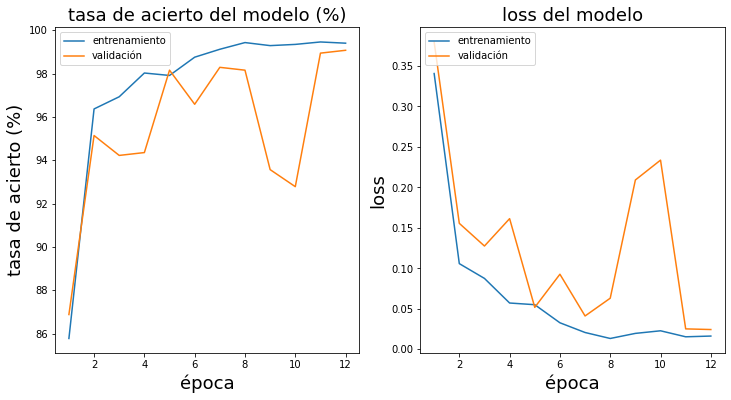

In [14]:
base_model = train_covid(resnet18, loss_fn, optimizer, epochs=12)

RESULTADOS OBTENIDOS

In [15]:
resnet18.eval()
correct = 0
total = 0
y_pred = []
y_real = []
with torch.no_grad():
  for data in test_loader:
    #inputs para la evaluación
    images, labels = data
    outputs = resnet18(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    #Para calcular las correctas encuentra la suma cuando las etiquetas son iguales a las predecidas calculadas anteriormente
    correct += (predicted == labels).sum().item()
    y_pred.extend(predicted.numpy().tolist())
    y_real.extend(labels.numpy().tolist())
    #y_pred.extend(predicted.numpy().tolist())
#Dividimos correctas entre totales para calcular la precisión
  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

Accuracy of the network on the test images: 97 %


(array([348.,   0.,   0.,   0.,   0., 211.,   0.,   0.,   0., 203.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

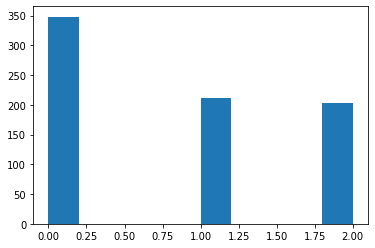

In [16]:
import matplotlib.pyplot as plt
plt.hist(y_pred)


CLASSIFICATION REPORT

In [17]:
print(classification_report(y_pred, y_real))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       348
           1       0.97      0.93      0.95       211
           2       0.96      0.97      0.97       203

    accuracy                           0.97       762
   macro avg       0.97      0.97      0.97       762
weighted avg       0.97      0.97      0.97       762



In [18]:
print(y_real)

[0, 0, 2, 0, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 1, 2, 2, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 2, 1, 0, 0, 0, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 2, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 1, 2, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 2, 1, 0, 1, 1, 1, 1, 2, 2, 0, 0, 2, 0, 1, 2, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 0, 0, 0, 0, 2, 1, 2, 0, 0, 2, 2, 0, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 2, 0, 2, 1, 0, 1, 0, 2, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 1, 1, 2, 2, 0, 2, 1, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 2, 2, 1, 0, 2, 2, 0, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 1, 0, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 2, 2, 2, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 

In [19]:
print(y_pred)

[0, 0, 2, 0, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 1, 2, 2, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 0, 1, 1, 2, 1, 0, 0, 0, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 2, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 1, 2, 2, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 2, 1, 0, 1, 1, 1, 1, 2, 2, 0, 0, 2, 0, 1, 2, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 0, 0, 0, 0, 2, 1, 2, 0, 0, 2, 2, 0, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 2, 0, 2, 1, 0, 1, 0, 2, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 1, 0, 0, 1, 2, 1, 1, 2, 2, 0, 2, 2, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2, 0, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 1, 0, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 2, 1, 0, 1, 0, 1, 2, 1, 2, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 2, 1, 0, 0, 

MATRIZ DE CONFUSIÓN

In [20]:

conf_matrix= confusion_matrix(y_pred, y_real)

In [21]:
dataset_indices=dataset.class_to_idx
import seaborn as sn

In [ ]:
print(dataset_indices)

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


In [22]:
conf_matrix = pd.DataFrame(conf_matrix, columns=['COVID', 'NORMAL', 'PNEUMONIA'], index=dataset_indices)
conf_matrix


,COVID,NORMAL,PNEUMONIA
COVID,348,0,0
NORMAL,7,196,8
Viral Pneumonia,0,6,197


[Text(32.99999999999999, 0.5, 'True label'),
 Text(0.5, 15.0, 'Predicted label')]

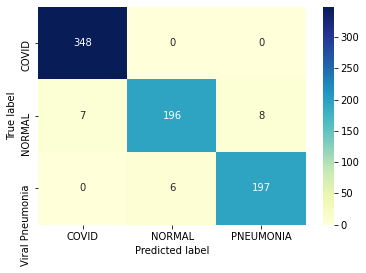

In [23]:
conf_matrix2 = pd.DataFrame(conf_matrix, columns=['COVID', 'NORMAL', 'PNEUMONIA'], index=dataset_indices)
ax = sn.heatmap(conf_matrix2, annot=True, cmap='YlGnBu', fmt='g')
ax.set(xlabel='Predicted label', ylabel='True label')

VISUALIZACIÓN DE LAS PREDICCIONES

In [54]:
class_names=dataset.classes
def show_images(images, labels, preds):
    plt.figure(figsize=(20,10))

    for i, image in enumerate(images): 
        plt.subplot(4,6,i+1, xticks=[], yticks=[])
        image=image.numpy().transpose((1,2,0))
        plt.imshow(image)
        col = 'green' if preds[i]==labels[i] else 'red'
        plt.xlabel(f'Actual : {class_names[int(labels[i].numpy())]}/ Predicted: {class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

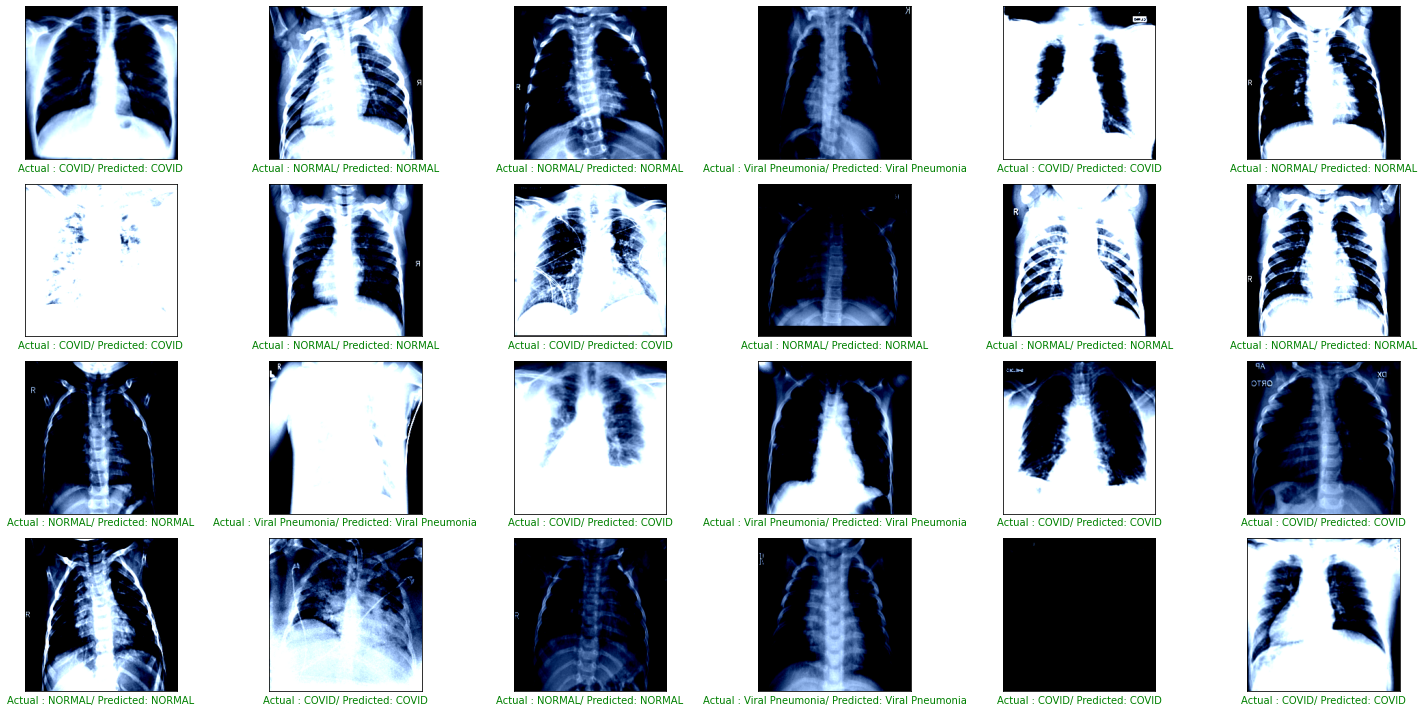

In [55]:
def show_preds() :
  resnet18.eval()
  images, labels = next(iter(test_loader))
  outputs = resnet18(images)
  _, preds = torch.max(outputs, 1)
  show_images(images, labels, preds)
show_preds()